# Computer Vision Tutorial

This tutorial is for getting the hang of computer vision algorithms, primarily within OpenCV, for a wide variety of use cases. Shoutout to the goat, Ralph.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

print("OpenCV version:", cv2.__version__)
print("Numpy version:", np.__version__)
print("Matplotlib version:", plt.matplotlib.__version__)

OpenCV version: 4.10.0
Numpy version: 2.1.3
Matplotlib version: 3.9.2


In [2]:
# helper functions, feel free to ignore these

def show_image(image, map="gray"):
    plt.axis("off")
    plt.imshow(image, cmap=map)
    plt.show()

## Thresholding


For this section, we're going to use an FTC game piece as our object.

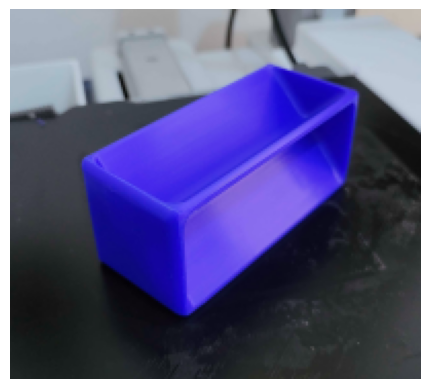

In [3]:
# Load the image
image = cv2.imread("images/ftc_piece.png")

# Show the image
show_image(image)

OpenCV reads images as BGR, meaning blue and red are swapped.

One important part of vision is being able to segment images. One way to segment images is to threshold it.

Thresholding works by taking values higher, lower, or in between certain "thresholds" in an image. You can represent images as a 2D matrix:

![Image In the Form of a 2D Matrix](notebook_imgs/image.png)

...where each square represents one pixel. Of course, this is a simplified representation of a black and white image. In black and white images, each pixel ranges from 0-255, signifying the intensity or brightness. As you can figure, a value of 0 represents black, while a value of 255 represents white.

However, if you were to draw an RGB image, it would look more like a 3D matrix:

![RGB image](notebook_imgs/rgb%20image.png)

...where each of the 3 sections (rows*columns) represents R, G, or B to create color.

### Grayscale Thresholding

In this section, we're going to work with grayscale images.

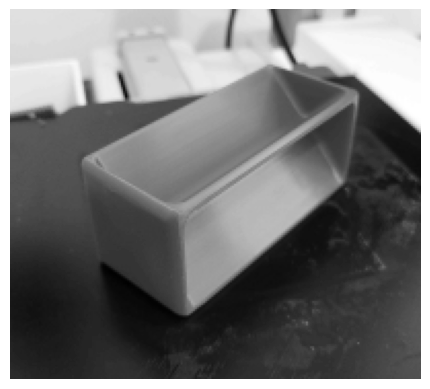

In [4]:
# Loads the image
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Display the image
show_image(gray_image)

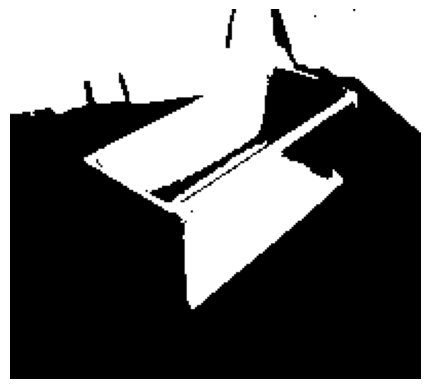

In [5]:
# Apply binary thresholding
# arguments are [image, threshold value, maxval, type of thresholding]
_, binary_thresh = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY) # _ is just the threshold value that we ignore in this case

# Display the thresholded image
show_image(binary_thresh)

In the above threshold, the function returns a mask that contains the values above 100 in the image. These values are white, while pixel values under 100 are set to black.

It's important to note that there are different types of thresholding. The one we used is binary. Here are a couple examples and their use cases:

**cv2.THRESH_BINARY**: Pixels above the threshold are set to maxval, and below are set to 0.  
**cv2.THRESH_BINARY_INV**: Inverse of THRESH_BINARY.  
**cv2.THRESH_TRUNC**: Pixels above the threshold are set to the threshold value; others remain unchanged.  
**cv2.THRESH_TOZERO**: Pixels below the threshold are set to 0; others remain unchanged.  
**cv2.THRESH_TOZERO_INV**: Inverse of THRESH_TOZERO.

We also have Otsu's threshold, which determines the threshold value automatically, and adaptive thresholding, which tends to do better if an image contains varying lighting conditions by setting a threshold for a pixel based on a small region surrounding it.

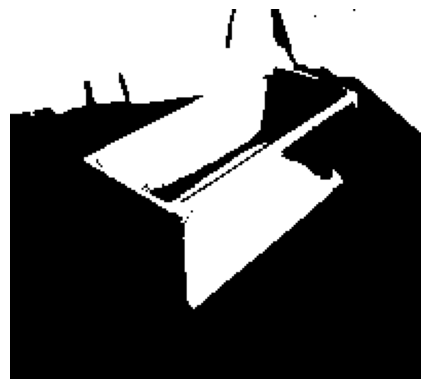

In [6]:
# Otsu's thresholding
_, otsu_thresholded = cv2.threshold(gray_image, 0, 255, cv2.THRESH_OTSU)

show_image(otsu_thresholded)

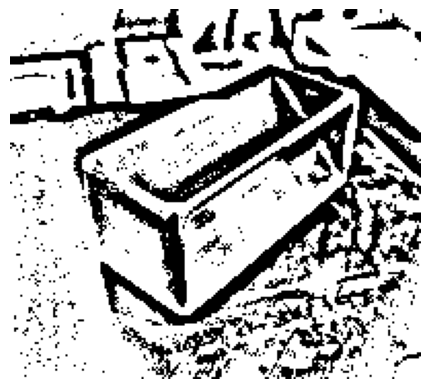

In [7]:
# Adaptive thresholding
# arguments are: [image, max value, adaptive method, threshold type, block size, constant]
adaptive_thresholded = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

show_image(adaptive_thresholded)

For adaptive thresholding, there are two threshold types:

**cv.ADAPTIVE_THRESH_MEAN_C**: The threshold value is the mean of the neighbourhood area minus the constant.  
**cv.ADAPTIVE_THRESH_GAUSSIAN_C**: The threshold value is a gaussian-weighted sum of the neighbourhood values minus the constant.  
- from OpenCV docs

There is no one size fits all. I encourage experimentation for your use cases to see what works best for you.

### Color thresholding

When dealing with colored images, we typically convert them to HSV first. For reference:

<img src="notebook_imgs/HSV.png" alt="hsv wheel" width="300"/>

This is the HSV color wheel.  
H - Hue  
S - Saturation  
V - Value

In OpenCV, H ranges from 0-179, S 0-255, and V 0-255. Here's a color map if you need it.

![hsv_map](notebook_imgs/hsv_map.png)

We use HSV because, at least in theory, thresholding should allow us to capture all instances of a specific color, regardless of the lighting. However, we'll see that in practice, this isn't the case.

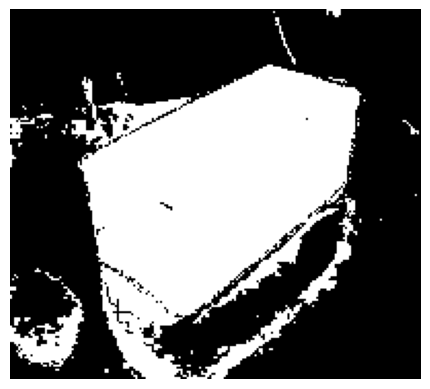

In [8]:
# [Hue, Saturation, Value]
lower_bound = np.array([10, 50, 0])
upper_bound = np.array([255, 255, 255])

# Convert the image to HSV
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Create a mask
mask = cv2.inRange(hsv_image, lower_bound, upper_bound)

# Show the mask
show_image(mask)

### Morphological Transformations

Often times, we'll need to perform transformations to get a better mask for our use case. Here are most of the transformations you'll often use:

**Erosion** - Removes pixels from boundaries of objects in image, useful for removing small white noise or separating connected objects.  
**Dilation** - Adds pixels to boundaries of objects, useful for closing small holes in an object.  
**Opening** - Erosion followed by dilation.  
**Closing** - Dilation followed by erosion.  
**Gradient** - The difference between dilation and erosion. Highlights edges of objects in the image.  
**Top Hat** - the difference between the input image and its opening. Highlights small, bright areas on a dark background.  
**Black Hat** - difference between the input image and its closing. Highlights small, dark areas on a bright background.

To do any of these transformations, you need a **kernel**. This is a shape that is going to go across the image and perform the transformation on a patch of pixels. You can create any shape by using a numpy array.

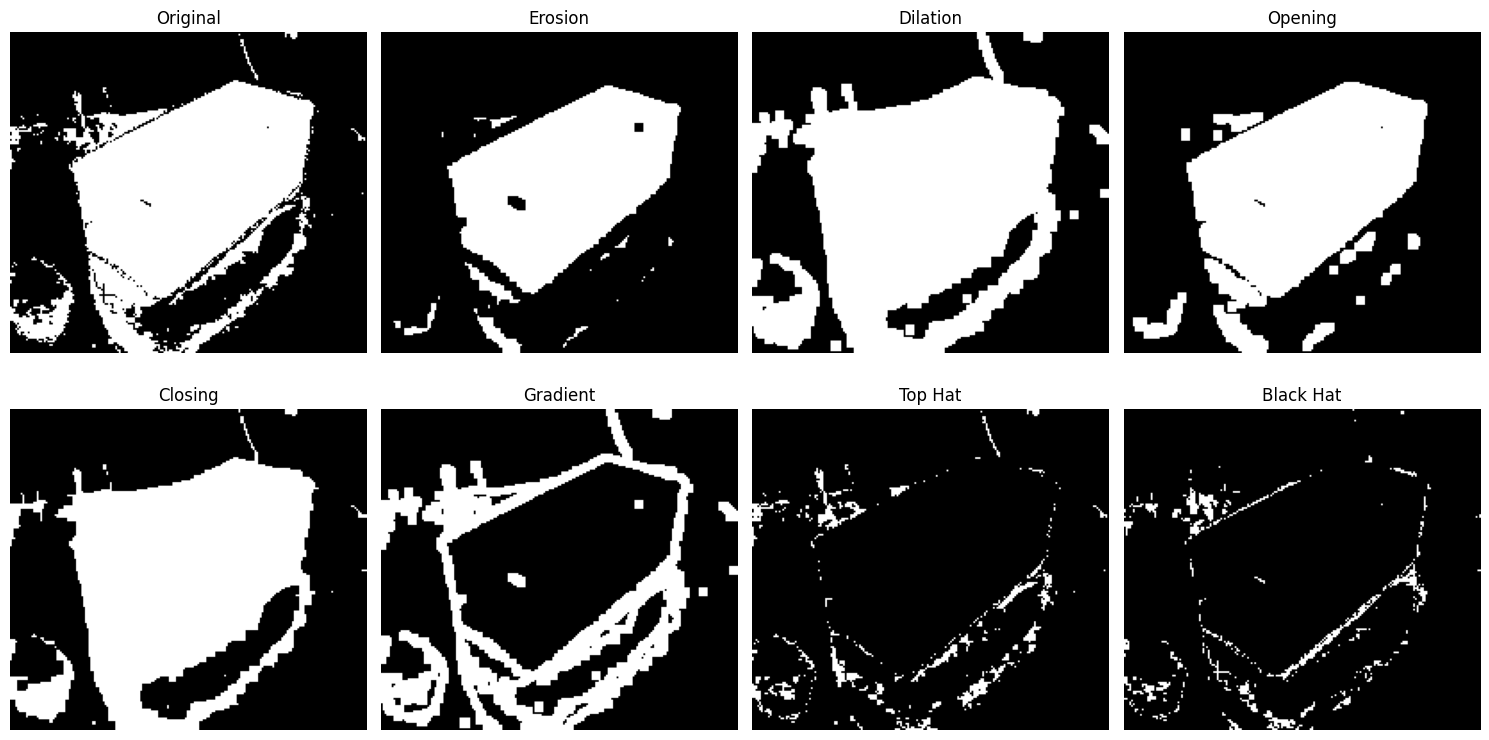

In [9]:
# We'll use a rectangular kernel for this example
kernel = np.ones((5, 5), np.uint8)

# Apply morphological transformations
eroded = cv2.erode(mask, kernel, iterations=1) # iterations is the number of times the operation is applied
dilated = cv2.dilate(mask, kernel, iterations=1)
opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
gradient = cv2.morphologyEx(mask, cv2.MORPH_GRADIENT, kernel)
tophat = cv2.morphologyEx(mask, cv2.MORPH_TOPHAT, kernel)
blackhat = cv2.morphologyEx(mask, cv2.MORPH_BLACKHAT, kernel)

# Display results
titles = ['Original', 'Erosion', 'Dilation', 'Opening', 'Closing', 'Gradient', 'Top Hat', 'Black Hat']
images = [mask, eroded, dilated, opened, closed, gradient, tophat, blackhat]

plt.figure(figsize=(15, 8))
for i in range(len(images)):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

## Edge Detection

An important part of computer vision is edge detection. This is the process of finding the edges of an object and then using it for other operations. 3 are covered here:

**Sobel** - used to detect edges in an image by finding areas where the intensity of the image changes significantly. It computes the gradient (rate of change) of pixel intensities in two directions: the horizontal and vertical axis. These gradients highlight edges.

**Laplacian** - detects edges by calculating the 2nd derivative of the image, which is teh rate of change of the rates of changes. This makes it sensitive to regions where intensity changes rapidly in any direction.

**Canny** - probably one of the most popular edge detection algorithms. It reduces noise (basically randomness in an image) using Gaussian filtering, calculates the gradient, goes through non-maximum suppression (thinning the edges, keeping ones that are most likely actually edges), and finally thresholds weak edges, keeping strong ones.

All these operations require a binary image mask (purely black and white), which is why thresholding is crucial.

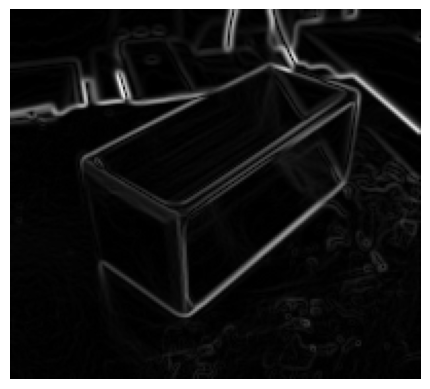

In [10]:
# cv2.CV_64F means that the result will be a 64-bit floating point
# 1 and 0 are the order of the derivatives in x and y directions, respectively. 
# If 1, 0, then we get the derivative in the x direction. 
# If 0, 1, then we get the derivative in the y direction.
# ksize is the size of the kernel (3x3 in this case)
sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, 0, 1, ksize=3)

# Combine gradients to get the magnitude of edges
sobel_combined = cv2.magnitude(sobel_x, sobel_y)

show_image(sobel_combined)

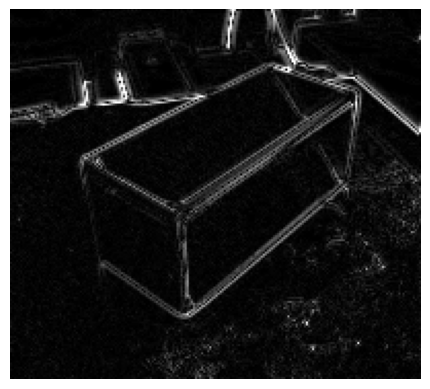

In [11]:
# Laplacian edge detection
laplacian = cv2.Laplacian(gray_image, cv2.CV_64F, ksize=3)

# Take the absolute value of the result to avoid negative pixel intensities
laplacian_abs = cv2.convertScaleAbs(laplacian)

show_image(laplacian_abs)

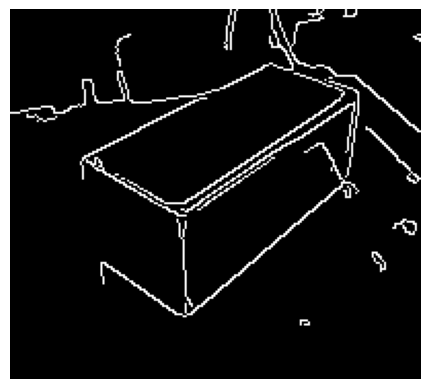

In [12]:
# 50 and 150 are the minVal and maxVal arguments
# Any gradient value larger than maxVal is considered to be an edge
# Any value below minVal is considered not to be an edge
# Canny edge detection
canny_edges = cv2.Canny(gray_image, 50, 150)

show_image(canny_edges)

In general, Canny detection is probably best for most use cases.

Before we close out this section, there's one transformation that is widely used for grayscale images. It's the Hough Circle Transform. This algorithm detects circular shapes in the image. Our object isn't very circular, so let's use a different image for this case.

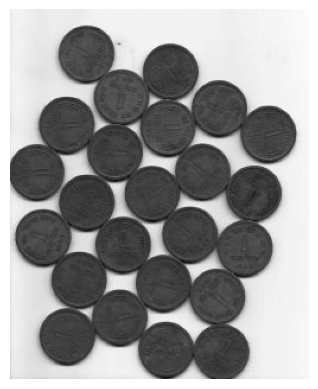

In [13]:
coins = cv2.imread("images/coins.png", cv2.IMREAD_GRAYSCALE)

show_image(coins)

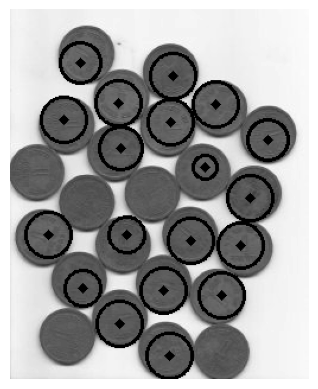

In [14]:
# Apply Hough Circle Transform
# dp it controls the resolution of the accumulator array used for 
# detecting circles. A higher dp value means a lower resolution 
# for the accumulator array, which can speed up the computation but 
# may reduce the accuracy of the detected circles
# minDist is the minimum distance between the centers of the detected circles
# param1 is the higher threshold for the Canny edge detector
# param2 is the accumulator threshold for the circle centers at the detection stage
# minRadius is the minimum circle radius
# maxRadius is the maximum circle radius
circles = cv2.HoughCircles(
    coins,
    cv2.HOUGH_GRADIENT,
    dp=1.2,
    minDist=20,
    param1=50,
    param2=30,
    minRadius=5,
    maxRadius=20
)

# Draw detected circles
if circles is not None:
    circles = np.uint16(np.around(circles))
    for circle in circles[0, :]:
        center = (circle[0], circle[1])  # Circle center
        radius = circle[2]  # Circle radius
        cv2.circle(coins, center, radius, (0, 255, 0), 2)  # Draw circle
        cv2.circle(coins, center, 2, (0, 0, 255), 3)  # Draw center

# Display the result
show_image(coins)

## Contours

Contours are curves connecting points with similar intensities. They are useful for shape analysis and object recognition. Contour detection is kind of like edge detection, and it also requires a grayscale image.

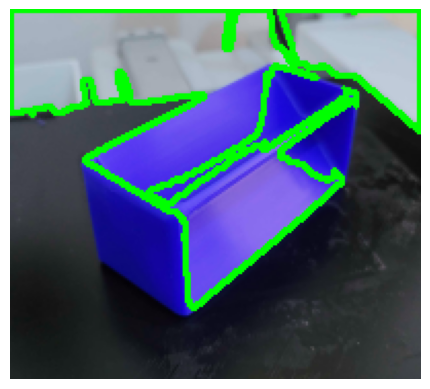

In [15]:
# Find contours
# _ is the hierarchy. If using RETR_EXTERNAL, we don't need it
contours, _ = cv2.findContours(binary_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours
contour_image = image.copy()

# draws the contours. -1 means all contours are drawn (use index to draw a specific contour)
# (0, 255, 0) is the color of the contours
# 2 is the thickness of the contours
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

show_image(contour_image)

Many times, we'll combine contour detection with edge detection algorithms. This allows us to do operations on the edges, such as shape analysis.

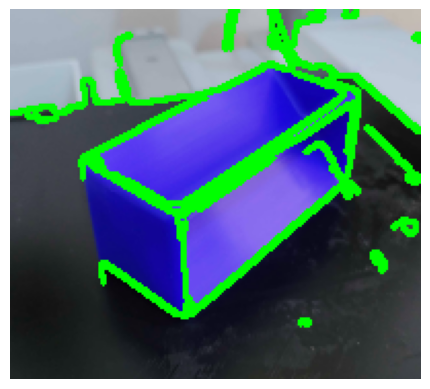

In [16]:
# Reset the image
contour_image = image.copy()

contours, _ = cv2.findContours(canny_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

show_image(contour_image)

### Contour Hierarchy

The arguments for the findContours method vary based on use case. The second argument is for the type of retrieval mode:

**cv2.CHAIN_APPROX_SIMPLE** - Retrieves only the outermost contours. Useful if you don't care about the inner boundaries.  
**cv2.RETR_LIST** - Retrieves all contours but does not organize them hierarchically. Useful when hierarchy relationships are irrelevant.  
**cv2.RETR_CCOMP** - Retrieves contours and organizes them into a two-level hierarchy. The 1st level are the external boundaries, the second are the boundaries of holes within those boundaires (essentially the internal edg3es of hollow or enclosed regions inside an object)  
**cv2.RETR_TREE** - Retrieves all contours and organizes them into a full tree structure. Useful for analyzing nested contours (like when objects are enclosed within other objects)

The third is the approximation method:

**cv2.CHAIN_APPROX_NONE** - stores all points along the contour boundary (accurate but more memory used)  
**cv2.CHAIN_APPROX_SIMPLE** - stores only necessary points to represent the contour boundary, which removes redundant points. For example, if you have a square, you'll only get the 4 corners of the square. This is usually more efficient and commonly used.

Let's see their use cases.

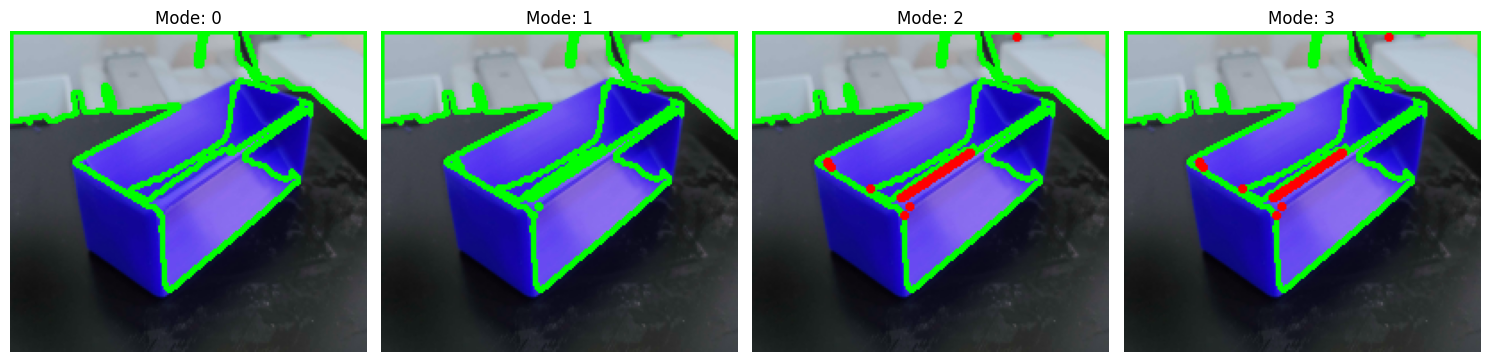

In [17]:
# Red represents inner contours
# Green represents outer contours

retrieval_modes = [
    cv2.RETR_EXTERNAL,
    cv2.RETR_LIST,
    cv2.RETR_CCOMP,
    cv2.RETR_TREE
]
cv2.CHAIN_APPROX_SIMPLE

# Create a figure to display the results
fig, axes = plt.subplots(1, len(retrieval_modes), figsize=(15, 10))

# Test all retrieval modes
for i, mode in enumerate(retrieval_modes):
    # Find contours
    contours, hierarchy = cv2.findContours(binary_thresh, mode, cv2.CHAIN_APPROX_SIMPLE)
    contour_image = image.copy()
    
    for k, contour in enumerate(contours):
        color = (0, 255, 0) if hierarchy[0][k][3] == -1 else (255, 0, 0)
        cv2.drawContours(contour_image, [contour], -1, color, 2)
    
    axes[i].imshow(contour_image)
    axes[i].set_title(f'Mode: {mode}')
    axes[i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Unlike with edge detection, we have ways to specify the types of contours we get. For example, how do we get the inner edges of an object? This is known as the **contour hierarchy**.

The hierarchy describes how contours are nested within each other. OpenCV uses a 4-element array for each contour:

[Next, Previous, First_Child, Parent]

**Next**: Index of the next contour at the same hierarchical level. -1 if none.  
**Previous**: Index of the previous contour at the same hierarchical level. -1 if none.  
**First_Child**: Index of the first child contour. -1 if none.  
**Parent**: Index of the parent contour. -1 if none.  

To better understand hierarchy, consider a circle with an empty circle inside it.

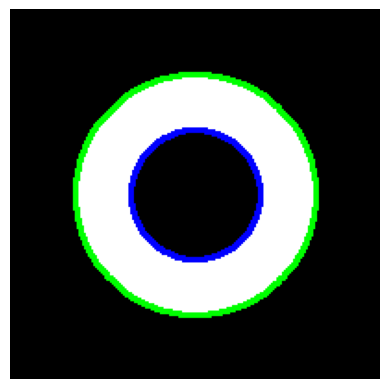

In [18]:
# Create a blank image
circle_image = np.zeros((200, 200), dtype=np.uint8)

# Draw a circle
cv2.circle(circle_image, (100, 100), 50, (255, 255, 255), 30)  # White circle with radius 50

# Find contours
contours, hierarchy = cv2.findContours(circle_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours
contour_image = cv2.cvtColor(circle_image, cv2.COLOR_GRAY2BGR)  # Convert to BGR for colored drawing

# Green for external contours, red for internal contours
for i, contour in enumerate(contours):
    color = (0, 255, 0) if hierarchy[0][i][3] == -1 else (0, 0, 255)
    cv2.drawContours(contour_image, [contour], -1, color, 2)

show_image(contour_image)

Outer Circle -> Parent contour.

Inner Circle -> Child contour.

Any other outer circle -> sibling of the first outer circle.

In [19]:
# Hierarchy information
print(hierarchy)

[[[-1 -1  1 -1]
  [-1 -1 -1  0]]]


In this case, the outermost shape is the first element in the list ([-1, -1, 1, -1]). This is because there is no "parent" (i.e. the contour has a parent of -1) for this contour, making it an outermost shape. 

However, the second element is an inner contour. We can see this because the 4th index is a "0," which means that the 0th element in the list is the outermost contour for the object.

You can also calculate the area and perimeters of the objects that a contour encapsulates. Let's use the circle example for simplicity.

In [20]:
for contour in contours:
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    print(f'Area: {area}, Perimeter: {perimeter}')

Area: 13268.0, Perimeter: 433.3036040067673
Area: 3824.0, Perimeter: 230.7939395904541


In general, it's best to use RETR_EXTERNAL + CHAIN_APPROX_SIMPLE for efficiency and detecting the outer boundaries of objects. Use RETR_TREE + CHAIN_APPROX_NONE if you require analysis of complex structures.

### Shape Analysis

We'll return to the FTC game piece for this section. 

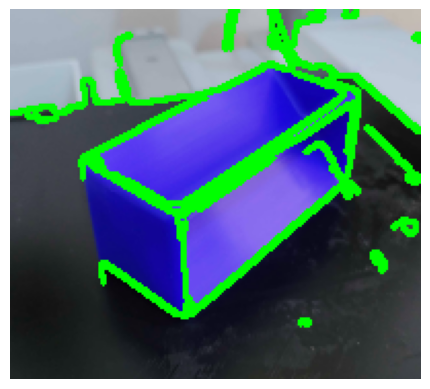

In [21]:
contour_image = image.copy()

contours, _ = cv2.findContours(canny_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

show_image(contour_image)

Using contours, we can fit shapes to contours. These techniques are useful for identifying object characteristics like size, orientation, and symmetry. Our first look will be at rectangles.

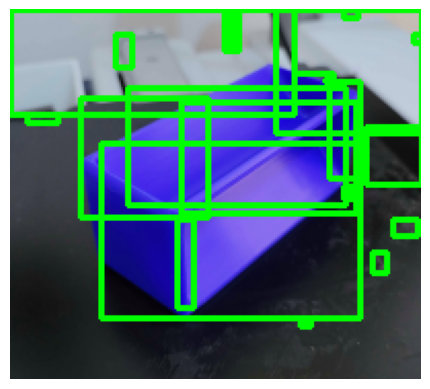

In [22]:
contour_image = image.copy()

# Create the rectangular bounding boxes
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(contour_image, (x, y), (x + w, y + h), (0, 255, 0), 2)

show_image(contour_image)

We can also find the smallest rectangle that encloses a contour, including rotations.

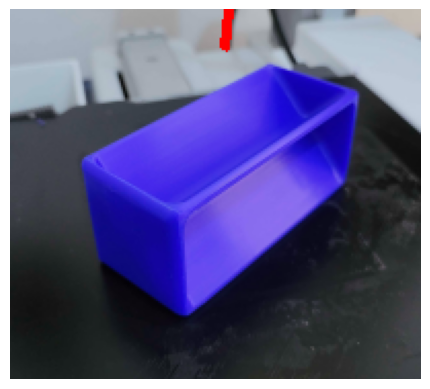

In [23]:
contour_image = image.copy()

# Compute rotated bounding rectangle
rect = cv2.minAreaRect(contour)

# Convert to box points and draw
box = cv2.boxPoints(rect)
box = np.int32(box)
cv2.drawContours(contour_image, [box], 0, (255, 0, 0), 2)

show_image(contour_image)


Next, we can fit ellipses. This provides a way to approximate contours as ovals. It requires the contour to have at least 5 points.

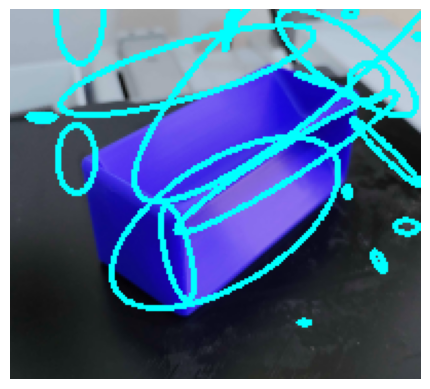

In [24]:
contour_image = image.copy()

for contour in contours:
    # Fit an ellipse if the contour has more than 5 points
    if len(contour) > 5:
        ellipse = cv2.fitEllipse(contour)
        cv2.ellipse(contour_image, ellipse, (0, 255, 255), 2)

show_image(contour_image)


The output of the fitEllipse function returns the center, axes lengths, and rotation angle.

We also have an important geometric concept called the convex hull. It is the smallest convex shape that encloses all points of a contour.

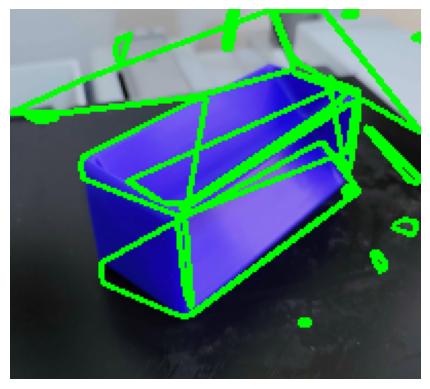

In [25]:
contour_image = image.copy()

contours, _ = cv2.findContours(canny_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for contour in contours:
    # Calculate the convex hull
    hull = cv2.convexHull(contour)
    cv2.drawContours(contour_image, [hull], -1, (0, 255, 0), 2)

show_image(contour_image)


And lastly, we have a few shape properties. Know these in case you need them for some kind of mathematical operation.

In [26]:
# Aspect Ratio
# The ratio of width to height of the bounding rectangle.
aspect_ratio = w / h
print("Aspect Ratio:", aspect_ratio)

# Extent
# The ratio of the contour area to the bounding rectangle area.
area = cv2.contourArea(contour)
rect_area = w * h
extent = area / rect_area
print("Extent:", extent)

# Solidity
# The ratio of the contour area to its convex hull area.
hull_area = cv2.contourArea(hull)
solidity = area / hull_area
print("Solidity:", solidity)

Aspect Ratio: 0.2
Extent: 0.0125
Solidity: 0.04878048780487805


In general...

**Bounding Rectangles**: Useful for locating and cropping regions of interest.  
**Ellipses**: Good for detecting elongated objects or analyzing orientation.   
**Convex Hull**: Used to analyze convexity defects or simplify contours.  
**Shape Descriptors (Aspect Ratio, Extent, Solidity)**: Aid in numerical classification of shapes.  

## Detection Algorithms

In computer vision, we sometimes need to capture specific patterns or points of interest, which are called features. This can include corners, or blobs, and are used to understand what is happening in an image.

This topic is extremely vast, so I'd encourage you to look outside of this notebook for other techniques. For our purposes, I'll introduce two.

First, we have ORB (Oriented FAST and Rotated BRIEF). This algorithm detects keypoints and computes descriptors that are invariant to scale, rotation, and illumination. It's also fast and efficient.

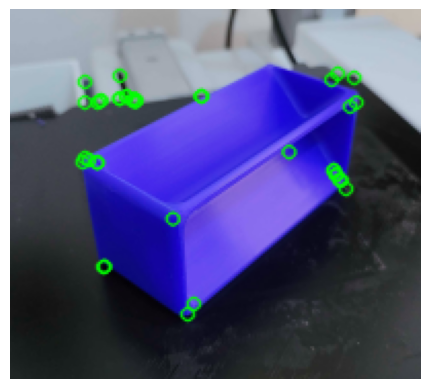

In [27]:
# Detect features using ORB
orb = cv2.ORB_create()
keypoints, descriptors = orb.detectAndCompute(gray_image, None)

# Draw keypoints
feature_image = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0))
show_image(feature_image)

Second, there's simple blob detection. It's very versatile and flexible.

Blob detection is used to find regions in an image that differ in properties versus its surrounding region. For example, perhaps the brightness of color might be different.

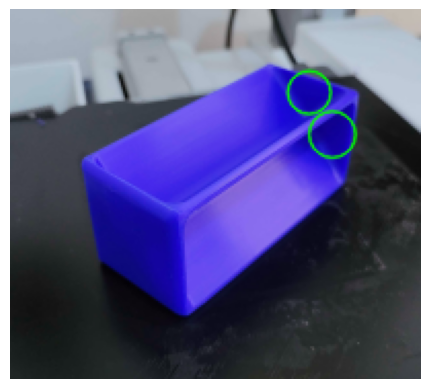

In [28]:
# Set up parameters for blob detection
params = cv2.SimpleBlobDetector_Params()

# Filter by area (size of the blob)
params.filterByArea = True
params.minArea = 100
params.maxArea = 10000

# Filter by circularity
params.filterByCircularity = True
params.minCircularity = 0.1

# Filter by convexity
params.filterByConvexity = True
params.minConvexity = 0.1

# Filter by inertia (how elongated a blob is)
params.filterByInertia = True
params.minInertiaRatio = 0.1

detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect(image)

output = cv2.drawKeypoints(
    image,
    keypoints,
    None,
    (0, 255, 0),
    cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

show_image(output)


## AprilTags

AprilTags are crucial in FRC and FTC. They essentially tell the robot its location in a fast and efficient way. This allows us to create some cooler stuff like auto-aim.

Depending on the library you use, there will be differing implementations. However, we're going to use the robotpy-apriltag library for our detector.

In [29]:
import cv2
from robotpy_apriltag import AprilTagDetector

# Load the image
image = cv2.imread("images/robots.png", cv2.IMREAD_GRAYSCALE)
output_image = cv2.cvtColor(cv2.imread("images/robots.png"), cv2.COLOR_BGR2RGB)

# Load the AprilTag detector
detector = AprilTagDetector()


There are several AprilTag families, so ensure that you know which family of AprilTags you need to use. Add this family to the detector, and voila, your detector will work!

Detected tag ID: 3
Detected tag ID: 5
Detected tag ID: 7
Detected tag ID: 8
Detected tag ID: 10
Detected tag ID: 10
Detected tag ID: 14


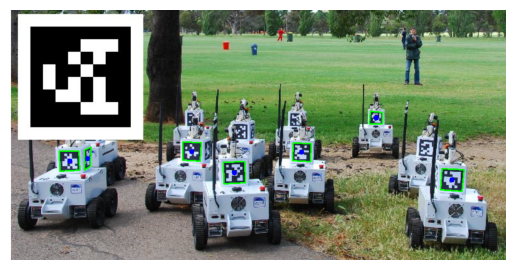

In [30]:
# We're only interested in the tag36h11 family
detector.addFamily("tag36h11")

# Detect AprilTags
tags = detector.detect(image)

# Process each detected tag
for tag in tags:
    # Draw the bounding box
    for i in range(4):  # AprilTags have 4 corners
        corner1 = tag.getCorner(i)
        corner2 = tag.getCorner((i + 1) % 4)
        pt1 = (int(corner1.x), int(corner1.y))
        pt2 = (int(corner2.x), int(corner2.y))
        cv2.line(output_image, pt1, pt2, (0, 255, 0), 2)

    # Draw the center
    center = tag.getCenter()
    center_pt = (int(center.x), int(center.y))
    cv2.circle(output_image, center_pt, 5, (0, 0, 255), -1)

    print(f"Detected tag ID: {tag.getId()}")

show_image(output_image)

...And that's it for this notebook. There are advanced techniques using AI, but that's a whole other subject matter on its own. AI is very constrained due to memory and other compute, but it is very powerful. If we get to it, then we'll get to it.

I hope you enjoyed!